In [348]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toyota-camry-from-auto-ru/toyota_prices.csv


In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [350]:
path_to_dataset = '/kaggle/input/toyota-camry-from-auto-ru/toyota_prices.csv'

In [351]:
ds = pd.read_csv(path_to_dataset, delimiter=';')
ds.head()

,Generation,Year,Odometer,CarType,Color,EngineVolume,Horsepower,OilType,Box,Drive,...,RearSuspensionType,FrontBrakes,RearBrakes,MaxSpeed,AccelerationTo100,FuelGrade,TypeSupercharger,NumberCylinders,ValvesPerCylinder,Price
0,VII (XV50),2012,153750,седан,чёрный,2.5,181,бензин,автоматическая,передний,...,"независимая, пружинная",дисковые вентилируемые,дисковые,210.0,9.0,аи-95,нет,4,4,1490000
1,VIII (XV70),2021,30000,седан,чёрный,2.0,150,бензин,автоматическая,передний,...,"независимая, пружинная",дисковые,дисковые,210.0,11.0,аи-95,нет,4,4,3000000
2,VII (XV50) Рестайлинг,2016,112483,седан,белый,2.5,181,бензин,автоматическая,передний,...,"независимая, пружинная",дисковые вентилируемые,дисковые,210.0,9.0,аи-95,нет,4,4,2395000
3,VI (XV40),2009,263705,седан,чёрный,2.4,167,бензин,автоматическая,передний,...,"независимая, пружинная",дисковые вентилируемые,дисковые,205.0,9.3,аи-95,нет,4,4,900000
4,VIII (XV70),2018,218000,седан,чёрный,3.5,249,бензин,автоматическая,передний,...,"независимая, пружинная",дисковые,дисковые,220.0,7.7,аи-95,нет,6,4,2599000


In [352]:
ds.shape

(3362, 26)

In [353]:
sorted([(col, ds[col].nunique(), ds[col].dtype) for col in ds.columns], key=lambda x: x[1])

[('State', 1, dtype('O')),
 ('FrontSuspensionType', 1, dtype('O')),
 ('TypeSupercharger', 1, dtype('O')),
 ('ValvesPerCylinder', 1, dtype('int64')),
 ('CarType', 2, dtype('O')),
 ('Drive', 2, dtype('O')),
 ('Wheel', 2, dtype('O')),
 ('Customs', 2, dtype('O')),
 ('CarClass', 2, dtype('O')),
 ('RearSuspensionType', 2, dtype('O')),
 ('FrontBrakes', 2, dtype('O')),
 ('RearBrakes', 2, dtype('O')),
 ('FuelGrade', 2, dtype('O')),
 ('NumberCylinders', 2, dtype('int64')),
 ('OilType', 3, dtype('O')),
 ('Box', 3, dtype('O')),
 ('NumberTransmissions', 4, dtype('float64')),
 ('EngineVolume', 7, dtype('float64')),
 ('Color', 12, dtype('O')),
 ('MaxSpeed', 12, dtype('float64')),
 ('Generation', 16, dtype('O')),
 ('AccelerationTo100', 25, dtype('float64')),
 ('Year', 33, dtype('int64')),
 ('Horsepower', 34, dtype('int64')),
 ('Price', 403, dtype('int64')),
 ('Odometer', 496, dtype('int64'))]

Удалим признаки, у которых только одно уникальное значение

In [354]:
one_unique_values = [col for col in ds.columns if ds[col].nunique() == 1]
one_unique_values

['State', 'FrontSuspensionType', 'TypeSupercharger', 'ValvesPerCylinder']

In [355]:
ds = ds.drop(one_unique_values, axis=1)

In [356]:
ds.shape

(3362, 22)

In [357]:
categorical_features = [feature for feature in ds.columns if ds[feature].dtype == 'object']
numerical_features = [feature for feature in ds.columns if ds[feature].dtype != 'object']

# Визуализация

## Матрица корреляции

In [358]:
corr_matrix = ds[numerical_features].corr()

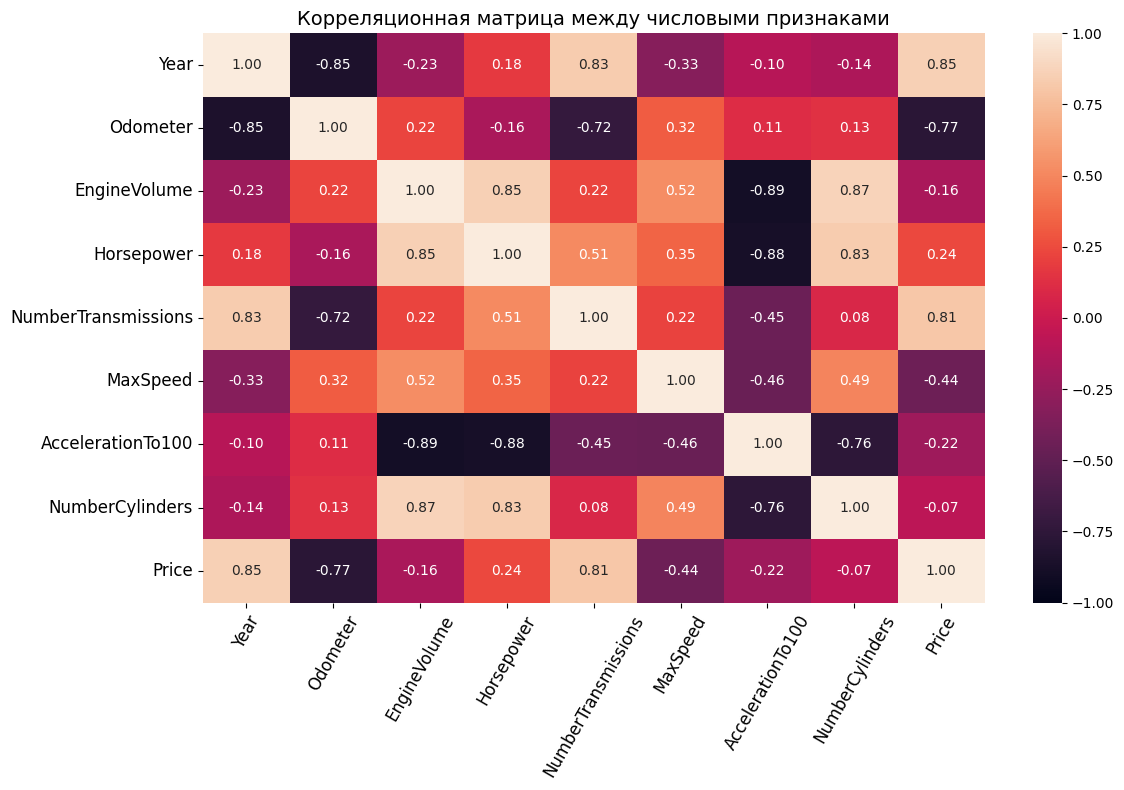

In [359]:
plt.figure(figsize=(12,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Корреляционная матрица между числовыми признаками', fontsize=14)
plt.xticks(rotation=60, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [292]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362 entries, 0 to 3361
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Generation           3362 non-null   object 
 1   Year                 3362 non-null   int64  
 2   Odometer             3362 non-null   int64  
 3   CarType              3362 non-null   object 
 4   Color                3362 non-null   object 
 5   EngineVolume         3362 non-null   float64
 6   Horsepower           3362 non-null   int64  
 7   OilType              3362 non-null   object 
 8   Box                  3362 non-null   object 
 9   Drive                3362 non-null   object 
 10  Wheel                3362 non-null   object 
 11  Customs              3362 non-null   object 
 12  CarClass             3362 non-null   object 
 13  NumberTransmissions  2513 non-null   float64
 14  RearSuspensionType   3358 non-null   object 
 15  FrontBrakes          3362 non-null   o

Text(0, 0.5, 'Price')

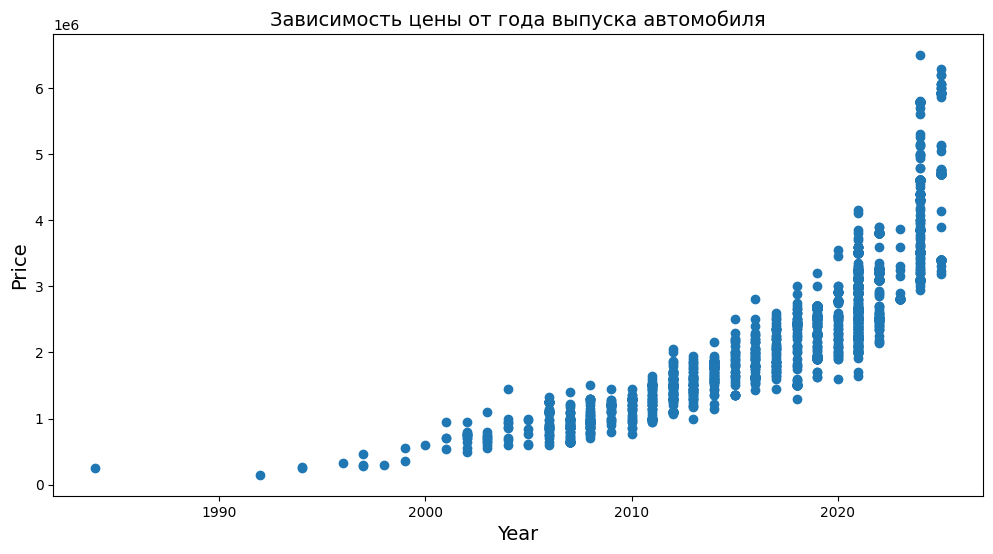

In [304]:
plt.figure(figsize=(12,6))
plt.scatter(data=ds, x='Year', y='Price')

plt.title('Зависимость цены от года выпуска автомобиля', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)

Text(0, 0.5, 'Price')

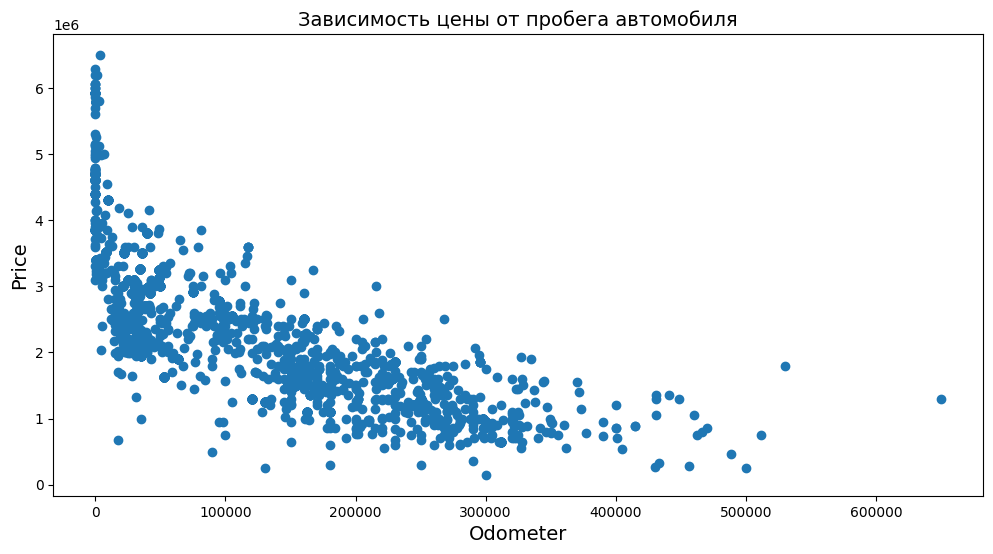

In [307]:
plt.figure(figsize=(12,6))
plt.scatter(data=ds, x='Odometer', y='Price')

plt.title('Зависимость цены от пробега автомобиля', fontsize=14)
plt.xlabel('Odometer', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Разбиение данных на тренировочный и тестовый наборы

In [204]:
from sklearn.model_selection import train_test_split, cross_validate
y = ds['Price']
X = ds.drop('Price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
categorical_features = [feature for feature in X.columns if ds[feature].dtype == 'object']
numerical_features = [feature for feature in X.columns if ds[feature].dtype != 'object']

In [206]:
X_train.shape

(2689, 21)

In [207]:
y_train.shape

(2689,)

# Предобработка данных

In [208]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362 entries, 0 to 3361
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Generation           3362 non-null   object 
 1   Year                 3362 non-null   int64  
 2   Odometer             3362 non-null   int64  
 3   CarType              3362 non-null   object 
 4   Color                3362 non-null   object 
 5   EngineVolume         3362 non-null   float64
 6   Horsepower           3362 non-null   int64  
 7   OilType              3362 non-null   object 
 8   Box                  3362 non-null   object 
 9   Drive                3362 non-null   object 
 10  Wheel                3362 non-null   object 
 11  Customs              3362 non-null   object 
 12  CarClass             3362 non-null   object 
 13  NumberTransmissions  2513 non-null   float64
 14  RearSuspensionType   3358 non-null   object 
 15  FrontBrakes          3362 non-null   o

In [209]:
print(categorical_features)
print(numerical_features)

['Generation', 'CarType', 'Color', 'OilType', 'Box', 'Drive', 'Wheel', 'Customs', 'CarClass', 'RearSuspensionType', 'FrontBrakes', 'RearBrakes', 'FuelGrade']
['Year', 'Odometer', 'EngineVolume', 'Horsepower', 'NumberTransmissions', 'MaxSpeed', 'AccelerationTo100', 'NumberCylinders']


In [210]:
ds.isnull().sum()

Generation                0
Year                      0
Odometer                  0
CarType                   0
Color                     0
EngineVolume              0
Horsepower                0
OilType                   0
Box                       0
Drive                     0
Wheel                     0
Customs                   0
CarClass                  0
NumberTransmissions     849
RearSuspensionType        4
FrontBrakes               0
RearBrakes                1
MaxSpeed                565
AccelerationTo100      1024
FuelGrade                 0
NumberCylinders           0
Price                     0
dtype: int64

In [211]:
feature_with_missing_values = [col for col in ds.columns if ds[col].isnull().any()]
feature_with_missing_values

['NumberTransmissions',
 'RearSuspensionType',
 'RearBrakes',
 'MaxSpeed',
 'AccelerationTo100']

In [212]:
from sklearn.impute import SimpleImputer

In [213]:
def fill_missing_values(data, features, group_by):
    for feature in features:
        
        value_type = data[feature].dtype
        
        if value_type == 'object':
            imputer = SimpleImputer(strategy='most_frequent')
            data[feature] = imputer.fit_transform(data[[feature]]).ravel()
        elif value_type in ['int', 'float']:
            data[feature] = data.groupby(group_by)[feature].transform(
            lambda x: x.fillna(x.median() if not x.isna().all() else data[feature].median()))

    return data
            

In [214]:
X_train.isnull().sum()

Generation               0
Year                     0
Odometer                 0
CarType                  0
Color                    0
EngineVolume             0
Horsepower               0
OilType                  0
Box                      0
Drive                    0
Wheel                    0
Customs                  0
CarClass                 0
NumberTransmissions    703
RearSuspensionType       3
FrontBrakes              0
RearBrakes               1
MaxSpeed               452
AccelerationTo100      834
FuelGrade                0
NumberCylinders          0
dtype: int64

**Данные для кросс валидации**

In [215]:
X = fill_missing_values(X, feature_with_missing_values, 'Generation')

**Данные для обучения и тестирования модели**

In [216]:
X_train = fill_missing_values(X_train, feature_with_missing_values, 'Generation')
X_test = fill_missing_values(X_test, feature_with_missing_values, 'Generation')

# Обучение моделей

In [238]:
from sklearn.linear_model import Ridge, Lasso

In [246]:
preprocess = ColumnTransformer(
    [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

linear_regression_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('model', LinearRegression())
    ]
)

random_forest_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('model', RandomForestRegressor())
    ]
)

xgbregressor_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('model', XGBRegressor())
    ]
)

In [254]:
def cross_validation_score(model, X, y):
    scoring = {
      'mae': 'neg_mean_absolute_error',
      'r2': 'r2'
    }

    results = cross_validate(model, X, y, cv=5, scoring=scoring)

    mae = -results['test_mae']
    r2 = results['test_r2']

    print("Худший MAE:", round(mae.max(), 4))
    print("Средний MAE:", round(mae.mean(), 4))
    print("Лучший MAE:", round(mae.min(), 4))
    print()
    print("Худший R2:", round(r2.min(), 4))
    print("Средний R^2:", round(r2.mean(), 4))
    print("Лучший R^2:", round(r2.max(), 4))

## Базовые настройки

### Линейная регрессия

In [255]:
cross_validation_score(linear_regression_pipeline, X, y)

Худший MAE: 411445.8048
Средний MAE: 318516.4181
Лучший MAE: 284243.065

Худший R2: 0.682
Средний R^2: 0.8211
Лучший R^2: 0.8914


### RandomForest

In [248]:
cross_validation_score(random_forest_pipeline, X, y)

Худший MAE: 326955.6581
Средний MAE: 193160.1401
Лучший MAE: 123749.8504

Худший R2: 0.7169
Средний R^2: 0.8919
Лучший R^2: 0.9673


### XGBRegressor

In [249]:
cross_validation_score(xgbregressor_pipeline, X, y)

Худший MAE: 347064.6336
Средний MAE: 197901.7897
Лучший MAE: 121764.6104

Худший R2: 0.7034
Средний R^2: 0.8887
Лучший R^2: 0.9673


## Поиск параметров

### RandomForest

In [265]:
# random_forest_param_grid = {
#     'model__n_estimators': [x for x in range(20, 600, 20)],
#     'model__max_depth': [x for x in range(5, 80, 5)]
# }

In [268]:
# random_forest_grid = GridSearchCV(
#     estimator=random_forest_pipeline,
#     param_grid=random_forest_param_grid,
#     cv=5,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1
# )

# random_forest_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Generation',
                                                                          'CarType',
                                                                          'Color',
                                                                          'OilType',
                                                                          'Box',
                                                                          'Drive',
                                                                          'Wheel',
                                                                          'Customs',
                                                                          'CarClass',
                                                                          'RearSuspensionType',
                                                                          'FrontBrakes',
                                                                          'RearBrakes',
                                                                          'FuelGrade'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75],
                         'model__n_estimators': [20, 40, 60, 80, 100, 120, 140,
                                                 160, 180, 200, 220, 240, 260,
                                                 280, 300, 320, 340, 360, 380,
                                                 400, 420, 440, 460, 480, 500,
                                                 520, 540, 560, 580]},
             scoring='neg_mean_absolute_error')

In [275]:
random_forest_grid.best_params_

{'model__max_depth': 75, 'model__n_estimators': 80}

Лучшие параметры, полученные при помощи GridSearch {'max_depth': 75, 'n_estimators': 80}

In [283]:
random_forest_new_param_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('model', RandomForestRegressor(max_depth=75, n_estimators=80))
    ]
)

In [284]:
cross_validation_score(random_forest_new_param_pipeline, X, y)

Худший MAE: 327208.0548
Средний MAE: 193500.3088
Лучший MAE: 125544.2968

Худший R2: 0.7224
Средний R^2: 0.8933
Лучший R^2: 0.9669


### XGBRegressor

In [279]:
# xgb_param_grid = {
#     'model__n_estimators': [x for x in range(20, 201, 20)],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # шаг градиентного спуска
#     'model__max_depth': [x for x in range(3, 19, 3)]
# }

In [280]:
# xgb_grid = GridSearchCV(
#     estimator=xgbregressor_pipeline,
#     param_grid=xgb_param_grid,
#     cv=5,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1
# )

# xgb_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Generation',
                                                                          'CarType',
                                                                          'Color',
                                                                          'OilType',
                                                                          'Box',
                                                                          'Drive',
                                                                          'Wheel',
                                                                          'Customs',
                                                                          'CarClass',
                                                                          'RearSuspensionType',
                                                                          'FrontBrakes',
                                                                          'RearBrakes',
                                                                          'FuelGrade'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=Non...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'model__max_depth': [3, 6, 9, 12, 15, 18],
                         'model__n_estimators': [20, 40, 60, 80, 100, 120, 140,
                                                 160, 180, 200]},
             scoring='neg_mean_absolute_error')

In [281]:
xgb_grid.best_params_

{'model__learning_rate': 0.2,
 'model__max_depth': 6,
 'model__n_estimators': 180}

Лучшие параметры, полученные при помощи GridSearch {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 180}

In [285]:
xgb_new_param_pipeline = Pipeline(
    [
        ('preprocess', preprocess),
        ('model', XGBRegressor(learning_rate=0.2, max_depth=6, n_estimators=180))
    ]
)

In [287]:
cross_validation_score(xgb_new_param_pipeline, X, y)

Худший MAE: 339882.4718
Средний MAE: 196217.2138
Лучший MAE: 122601.9829

Худший R2: 0.7095
Средний R^2: 0.8897
Лучший R^2: 0.9672


# Результаты

In [366]:
models = {
    'Линейная регрессия': linear_regression_pipeline,
    'Случайный лес': random_forest_new_param_pipeline,
    'XGBRegressor': xgb_new_param_pipeline
}

for name, model in models.items():
    print(name+'\n')
    cross_validation_score(model, X, y)
    print()
    print('='*20)
    print()

Линейная регрессия

Худший MAE: 411445.8048
Средний MAE: 318516.4181
Лучший MAE: 284243.065

Худший R2: 0.682
Средний R^2: 0.8211
Лучший R^2: 0.8914


Случайный лес

Худший MAE: 331484.6402
Средний MAE: 193250.2884
Лучший MAE: 123712.4335

Худший R2: 0.7116
Средний R^2: 0.8919
Лучший R^2: 0.9673


XGBRegressor

Худший MAE: 339882.4718
Средний MAE: 196217.2138
Лучший MAE: 122601.9829

Худший R2: 0.7095
Средний R^2: 0.8897
Лучший R^2: 0.9672




## Вывод

**Лучшие, примерно равные результаты показали RandomForestRegressor и XGBRegresor**